# **Computer Vision 2023 Assignment 2: Image Matching & Retrieval**

In this prac, you will experiment with image feature detectors, descriptors and matching. **There are 3 main parts to the prac:**

- Matching an object in a pair of images

- Searching for an object in a collection of images

- Analysis and discussion of results

<br/>

## **General Instructions**

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly.

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'

This will also remove the preamble text from each question. It has been packaged into a small notebook you can run in colab, called notebooktopdf.ipynb


We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

As with the last assignment it is somewhat up to you how you answer each question. Ensure that the outputs and report are clear and easy to read so that the markers can rapidly assess what you have done, why, and how deep is your understanding. This includes:

- Sizing, arranging and captioning image outputs appropriately

- Explaining what you have done clearly and concisely

- Clearly separating answers to each question

<br/>

## **Data**

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. You should copy these data into a directory A2_smvs, keeping the directory structure the same as in the zip file.  

Within each category (within each folder), there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>.

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

**Do not submit your own copy of the data or rename any files or folders!** For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [1]:
# Numpy is the Main Package for Scientific Computing with Python
import numpy as np
import cv2

# Matplotlib is a Useful Plotting Library for Python
import matplotlib.pyplot as plt

# To Display Images for Conversion to PDF
from IPython.display import HTML, display

# Import Code Book with Custom Function Definitions
from a2code import *

# This Code is to Make Matplotlib Figures Appear Inline in the Notebook Rather than in a New Window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)    # Set Default Size of Plots, Can Be Changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some More Magic so that the Notebook Will Reload External Python Modules. see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
def draw_outline(ref, query, model):
    """
    Draws the outline of the reference image projected onto the query image using a given perspective transformation matrix.
    Parameters:
        ref (ndarray): The reference image (grayscale or color).
        query (ndarray): The query image in which to draw the outline.
        model (ndarray): The homography matrix from query to reference image.
    """
    # Get Dimensions of the Reference Image
    h, w = ref.shape[:2]

    # Define the Four Corners of the Reference Image
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Transform the Corners Using the Homography Matrix
    dst = cv2.perspectiveTransform(pts, model)

    # Copy the Query Image and Draw the Projected Outline
    img = query.copy()
    img = cv2.polylines(img, [np.int32(dst)], isClosed=True, color=(255, 0, 0), thickness=3, lineType=cv2.LINE_AA)

    # Return the Result
    return img


def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask):
    """
    Draws the inlier keypoint matches between two images.
    Parameters:
        img1, img2 (ndarray): The reference and query images.
        kp1, kp2 (list): Keypoints from both images.
        matches (list): Filtered list of good matches.
        matchesMask (ndarray): Mask indicating which matches are inliers (from cv2.findHomography).
    """
    # Flatten the Mask Array
    matchesMask = matchesMask.ravel().tolist()

    # Set Drawing Parameters: Green Colour for Inliers
    draw_params = dict(
        matchColor=(0, 255, 0),      # Green for Inlier Matches
        singlePointColor=None,       # No Circles for Unmatched Keypoints
        matchesMask=matchesMask,     # Only Show Inliers
        flags=2                      # Use Default Drawing Style
    )

    # Draw Matches
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

    # Return the Image
    return img3


def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draws epipolar lines on the first image and the corresponding points on both images to visualise epipolar geometry.
    Parameters:
        img1 (ndarray): First (reference) image for drawing lines.
        img2 (ndarray): Second image with points.
        lines (ndarray): Epilines corresponding to points in img2.
        pts1 (ndarray): Points in img1.
        pts2 (ndarray): Corresponding points in img2.
    Returns:
        img1 (ndarray): Image with epipolar lines.
        img2 (ndarray): Image with marked points.
    """
    # Get Image Dimensions (assuming grayscale input)
    r, c = img1.shape

    # Convert to Colour for Drawing
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Draw Each Epipolar Line and its Corresponding Points
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())  # Random Colour for Each Line

        # Compute Two Points on the Epipolar Line
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0]*c)/r[1]])

        # Draw the Epipolar Line on img1
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)

        # Draw the Corresponding Points on Both Images
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)

    return img1, img2

<br/><br/>

# **Question 1: Matching an Object in a Pair of Images *(60%)***


In this question, the aim is to accurately locate a reference object in a query image, for example:

![Books](book.png "Books")

**0. Download and read through the paper [ORB: an efficient alternative to SIFT or SURF](https://www.researchgate.net/publication/221111151_ORB_an_efficient_alternative_to_SIFT_or_SURF) by Rublee et al.** You don't need to understand all the details, but try to get an idea of how it works. ORB combines the FAST corner detector and the BRIEF descriptor. BRIEF is based on similar ideas to the SIFT descriptor we covered week 3, but with some changes for efficiency.

**1. [Load images]** Load the first (reference, query) image pair from the "book_covers" category using opencv (e.g. `img=cv2.imread()`). Check the parameter option in "
cv2.imread()" to ensure that you read the gray scale image, since it is necessary for computing ORB features.

**2. [Detect features]** Create opencv ORB feature extractor by `orb=cv2.ORB_create()`. Then you can detect keypoints by `kp = orb.detect(img,None)`, and compute descriptors by `kp, des = orb.compute(img, kp)`. You need to do this for each image, and then you can use `cv2.drawKeypoints()` for visualisation.

**3. [Match features]** As ORB is a binary feature, you need to use HAMMING distance for matching, e.g., `bf = cv2.BFMatcher(cv2.NORM_HAMMING)`. Then you are requried to do KNN matching (k=2) by using `bf.knnMatch()`. After that, you are required to use "ratio_test". Ratio test was used in SIFT to find good matches and was described in the lecture. By default, you can set `ratio=0.8`.

**4. [Plot and analyse]** You need to visualise the matches by using the `cv2.drawMatches()` function. Also you can change the ratio values, parameters in `cv2.ORB_create()`, and distance functions in `cv2.BFMatcher()`. Please discuss how these changes influence the match numbers.


In [ ]:
# Load Images as Grey Scale
# BookCover Images
img1 = cv2.imread('A2_smvs/book_covers/Reference/001.jpg', 0)
if not np.shape(img1):
  # Error Message & Print Current Working Dir
  print("Could not load img1. Check the path, filename and current working directory\n")

img2 = cv2.imread("A2_smvs/book_covers/Query/001.jpg", 0)
if not np.shape(img2):
  # Error Message & Print Current Working Dir
  print("Could not load img2. Check the path, filename and current working directory\n")


# Landmark Images
img3 = cv2.imread('A2_smvs/landmarks/Reference/001.jpg', 0)
if not np.shape(img3):
  # Error Message & Print Current Working Dir
  print("Could not load img3. Check the path, filename and current working directory\n")

img4 = cv2.imread("A2_smvs/landmarks/Query/001.jpg", 0)
if not np.shape(img4):
  # Error Message & Print Current Working Dir
  print("Could not load img4. Check the path, filename and current working directory\n")


# Museum Paintings Images
img5 = cv2.imread('A2_smvs/museum_paintings/Reference/001.jpg', 0)
if not np.shape(img5):
  # Error Message & Print Current Working Dir
  print("Could not load img5. Check the path, filename and current working directory\n")

img6 = cv2.imread("A2_smvs/museum_paintings/Query/001.jpg", 0)
if not np.shape(img6):
  # Error Message & Print Current Working Dir
  print("Could not load img6. Check the path, filename and current working directory\n")

In [ ]:
def detect_and_match_features(img1, img2, orb_features=500, ratio=0.8, distance_metric=cv2.NORM_HAMMING):
    """
    Detects and matches ORB features between two images using KNN and Lowe's ratio test.
    Parameters:
        img1 (ndarray): Reference image.
        img2 (ndarray): Query image.
        orb_features (int): Number of ORB features to detect. Default is 500.
        ratio (float): Threshold for Lowe's ratio test. Default is 0.8.
        distance_metric (int): Distance metric for the matcher. Default is cv2.NORM_HAMMING.
    Returns:
        img1_kp (ndarray): Reference image with keypoints drawn.
        img2_kp (ndarray): Query image with keypoints drawn.
        matched_img (ndarray): Image showing good matches.
        good_matches (list): List of good matches after ratio test.
    """
    
  # ---------- PART 2: Compute Detector & Descriptor ----------
    # Create Feature Extractor
    orb = cv2.ORB_create(nfeatures=orb_features)

    # Find the Keypoints & Descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Draw Keypoints
    img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
    img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)


  # ---------- PART 3: Matching Features Across Images ----------
    # Create Brute Force Matcher with Hamming Distance (Since ORB is Binary)
    bf = cv2.BFMatcher(distance_metric, crossCheck=False)

    # KNN Match with k=2 for Each Descriptor
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply Lowe's Ratio Test to Find Good Matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    # Draw Good Matches
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Return Useful Information for Visualisation
    return img1_kp, img2_kp, kp1, kp2, matched_img, good_matches


# ---------- PART 4: Plotting & Analysing Matches ----------
# Default Values
img1_kp, img2_kp, _, _, matched_img, good_matches = detect_and_match_features(img1, img2, orb_features=500, ratio=0.8, distance_metric=cv2.NORM_HAMMING)
display_matching_results(img1_kp, img2_kp, matched_img, title_suffix="(500 Features, Ratio 0.8)", matches="Ratio = 0.8, Distance = Hamming", features="(500 Features)")
print(f"Number of Good Matches After Ratio Test: {len(good_matches)}")

# Lower Ratio Value
img1_kp, img2_kp, _, _, matched_img, good_matches = detect_and_match_features(img1, img2, orb_features=500, ratio=0.5, distance_metric=cv2.NORM_HAMMING)
display_matching_results(img1_kp, img2_kp, matched_img, title_suffix="(500 Features, Ratio 0.5)", matches="Ratio = 0.5, Distance = Hamming", features="(500 Features)")
print(f"Number of Good Matches After Ratio Test: {len(good_matches)}")

# Higher Ratio Value
img1_kp, img2_kp, _, _, matched_img, good_matches = detect_and_match_features(img1, img2, orb_features=500, ratio=0.9, distance_metric=cv2.NORM_HAMMING)
display_matching_results(img1_kp, img2_kp, matched_img, title_suffix="(500 Features, Ratio 0.9)", matches="Ratio = 0.9, Distance = Hamming", features="(500 Features)")
print(f"Number of Good Matches After Ratio Test: {len(good_matches)}")

# More Features
img1_kp, img2_kp, _, _, matched_img, good_matches = detect_and_match_features(img1, img2, orb_features=1000, ratio=0.8, distance_metric=cv2.NORM_HAMMING)
display_matching_results(img1_kp, img2_kp, matched_img, title_suffix="(1000 Features, Ratio 0.8)", matches="Ratio = 0.8, Distance = Hamming", features="(1000 Features)")
print(f"Number of Good Matches After Ratio Test: {len(good_matches)}")

# Less Features
img1_kp, img2_kp, _, _, matched_img, good_matches = detect_and_match_features(img1, img2, orb_features=250, ratio=0.8, distance_metric=cv2.NORM_HAMMING)
display_matching_results(img1_kp, img2_kp, matched_img, title_suffix="(250 Features, Ratio 0.8)", matches="Ratio = 0.8, Distance = Hamming", features="(250 Features)")
print(f"Number of Good Matches After Ratio Test: {len(good_matches)}")

# Changing Distance Metrics
img1_kp, img2_kp, _, _, matched_img, good_matches = detect_and_match_features(img1, img2, orb_features=500, ratio=0.8, distance_metric=cv2.NORM_L2)
display_matching_results(img1_kp, img2_kp, matched_img, title_suffix="(500 Features, Ratio 0.8)", matches="Ratio = 0.8, Distance = L2 Norm", features="(500 Features)")
print(f"Number of Good Matches After Ratio Test: {len(good_matches)}")

# Changing Distance Metrics
img1_kp, img2_kp, _, _, matched_img, good_matches = detect_and_match_features(img1, img2, orb_features=500, ratio=0.8, distance_metric=cv2.NORM_HAMMING2)
display_matching_results(img1_kp, img2_kp, matched_img, title_suffix="(500 Features, Ratio 0.8)", matches="Ratio = 0.8, Distance = Hamming2", features="(500 Features)")
print(f"Number of Good Matches After Ratio Test: {len(good_matches)}")




As can be seen above, when we decrease the ratio value for Lowe’s ratio test threshold, there are fewer good feature matches, only 19 compared to 131 with the default value. Additionally, as the ratio approaches 1, more points are classified as good matches, leading to a total of 242. This occurs because Lowe’s ratio test filters ambiguous matches based on the distance between the best and second-best matches. When the ratio threshold is set lower, it becomes more selective, accepting only those matches where the best match is significantly better than the second-best. As a result, a lower ratio improves match precision but reduces the total number of matches. In contrast, a higher ratio is less strict, increasing recall but potentially introducing false matches. The default value of 0.75–0.8 typically provides a good balance between precision and robustness.

In a similar way, increasing the number of features in the `cv2.ORB_create()` function leads to more good matches being found. For instance, increasing to 1000 features resulted in 221 good matches. Conversely, reducing the number to 250 dropped the good matches to just 59. This occurs because selecting fewer features limits the number of key points available for matching, reducing the likelihood of strong correspondences. Increasing the number of features provides more key points to work with, improving coverage and match potential. However, more features may also include less distinctive or noisier key points, which can introduce weaker or false matches. Therefore, while increasing features generally boosts match quantity, it can also reduce overall precision if too many noisy or irrelevant key points are included. Therefore on reasonably feature-rich objects like book covers, the default feature value of 500 works well.

Finally, the effect of different distance metrics was tested by looking at Hamming, L2 Norm, and Hamming2 as distance metrics for ORB feature matching. Hamming produced the highest number of good matches (131), as it directly compares binary descriptors, which ORB uses. L2 Norm, on the other hand, yielded only 51 matches, as it is designed for continuous descriptors like SIFT, and treating binary data as continuous causes mismatches. Hamming2 gave 109 matches, performing better than L2 but still less efficiently than Hamming due to its slight modifications for binary data. The differences arise because Hamming is specifically optimised for binary descriptors like ORB, efficiently comparing bitstrings. L2 Norm, being suited for continuous data, struggles with binary descriptors, resulting in poor performance. Hamming2 is a variant of Hamming, but it doesn't fully optimise binary data comparison, leading to fewer good matches than Hamming. In conclusion, Hamming is the most effective metric for ORB, while the other metrics are less suitable due to the mismatch with the binary nature of the descriptors.

---

<br/>



**5.1. Estimate a homography transformation based on the matches, using `cv2.findHomography()`. Display the transformed outline of the first reference book cover image on the query image, to see how well they match.**

- We provide a function `draw_outline()` to help with the display, but you may need to edit it for your needs.

- Try the 'least squre method' option to compute homography, and visualise the inliers by using `cv2.drawMatches()`. Explain your results.

- Again, you don't need to compare results numerically at this stage. Comment on what you observe visually.

In [ ]:
# Call Default ORB Method
_, _, kp1, kp2, matched_img, good_matches = detect_and_match_features(img1, img2)

# Convert the Keypoints to Numpy Arrays
kps1 = np.float32([kp.pt for kp in kp1])
kps2 = np.float32([kp.pt for kp in kp2])

# Create src_pts & dst_pts as Float Arrays to be Passed into cv2.findHomography
src_pts = np.float32([kps1[m.queryIdx] for m in good_matches])
dst_pts = np.float32([kps2[m.trainIdx] for m in good_matches])

# Compute the Homography Matrix using RANSAC (Least Squares Method by Default)
model, mask = cv2.findHomography(src_pts, dst_pts, method=0)

# Display the Outline and the Inliers Seperatly
outline_img = draw_outline(img1, img2, model)
inliers_img = draw_inliers(img1, img2, kp1, kp2, good_matches, mask)
display_side_by_side(outline_img, inliers_img, title1="Projected Outline", title2="Inlier Matches", global_title="Least Square Homography Method")



When using the default Least Squares method `(method=0)` for computing the homography, it is clear that the outline projected onto the book did not align properly, appearing flatter than expected. This misalignment likely stems from the absence of inlier filtering, which makes the Least Squares method highly sensitive to outliers. In this case, there were 131 good matches, and surprisingly, the same 131 matches were retained as inliers in the output of `cv2.findHomography()`. Since the Least Squares method does not differentiate between inliers and outliers, even a few incorrect or noisy matches can distort the homography, especially if the matches are spread across the image in a way that increases the error. The homography matrix attempts to minimise the squared reprojection error, which works under the assumption that all the points are accurate. However, this assumption fails when there are unreliable matches, as it does not account for the possibility of outliers.

The result is that the homography projection is skewed, leading to noticeable distortion. In the image, although all matches are technically on the book cover, the method's sensitivity to incorrect matches still caused misalignment. This issue is further highlighted by the mask returned by `cv2.findHomography()`, which either returns None or consists entirely of 1s, indicating no inlier filtering was applied. The absence of filtering means the method treats all points equally, which can result in a poor transformation when the data contains noise or incorrect matches. In contrast, alternative methods such as RANSAC would filter out these outliers, resulting in a more accurate projection by focusing on the inliers.

<br/>



**5.2. Try the RANSAC option to compute homography. Change the RANSAC parameters, and explain your results. Print and analyse the inlier numbers.**

In [ ]:
def runRansac(img1, img2, title=None, ransac_thresh=5.0, max_iters=2000, confidence=0.995):
    """
    Detects features, matches them, and computes homography using RANSAC. 
    Then displays the projected outline and inlier matches.
    Parameters:
        img1 (ndarray): Reference image.
        img2 (ndarray): Query image to align.
        title (str): Optional global title for visualization.
        ransac_thresh (float): Maximum allowed reprojection error (in pixels) to treat a point pair as an inlier.
        max_iters (int): Maximum number of RANSAC iterations.
        confidence (float): Desired confidence level for estimated homography (between 0 and 1).
    Outputs:
        - Displays side-by-side visualizations of projected outline and inlier matches.
        - Prints the number of inliers vs total matches and percentage of inliers.
    """
    # Detect ORB Keypoints & Match Them
    _, _, kp1, kp2, matched_img, good_matches = detect_and_match_features(img1, img2)

    # Extract Matched Keypoint Co-ordinates
    kps1 = np.float32([kp.pt for kp in kp1])
    kps2 = np.float32([kp.pt for kp in kp2])
    src_pts = np.float32([kps1[m.queryIdx] for m in good_matches])
    dst_pts = np.float32([kps2[m.trainIdx] for m in good_matches])

    # Compute Homography Using RANSAC
    model, mask = cv2.findHomography(
        src_pts, dst_pts,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransac_thresh,
        maxIters=max_iters,
        confidence=confidence
    )

    # Draw Results
    outline_img = draw_outline(img1, img2, model)
    inliers_img = draw_inliers(img1, img2, kp1, kp2, good_matches, mask)
    display_side_by_side(outline_img, inliers_img,
                         title1="Projected Outline",
                         title2="Inlier Matches",
                         global_title=title or f"RANSAC (thresh={ransac_thresh}, iter={max_iters}, conf={confidence})")

    # Print Analysis of Inliers
    inliers_count = int(mask.sum())
    total_matches = len(good_matches)
    inlier_ratio = 100.0 * inliers_count / total_matches

    print(f"RANSAC Results:")
    print(f" - Inliers: {inliers_count}")
    print(f" - Total Matches: {total_matches}")
    print(f" - Inlier Ratio: {inlier_ratio:.2f}%")



# ---------- RANSAC Testing ----------
# Defualt Value Testing
runRansac(img1=img1, img2=img2)

# Lower RANSAC Threshold
runRansac(img1=img1, img2=img2, ransac_thresh=2.0, max_iters=2000, confidence=0.995)

# Higher RANSAC Threshold
runRansac(img1=img1, img2=img2, ransac_thresh=10.0, max_iters=2000, confidence=0.995)

# Lower Maximum Iterations
runRansac(img1=img1, img2=img2, ransac_thresh=5.0, max_iters=1000, confidence=0.995)

# Higher Maximum Iterations
runRansac(img1=img1, img2=img2, ransac_thresh=5.0, max_iters=5000, confidence=0.995)

# Higher Confidence Level
runRansac(img1=img1, img2=img2, ransac_thresh=5.0, max_iters=2000, confidence=0.999)

# Lower Confidence Level
runRansac(img1=img1, img2=img2, ransac_thresh=5.0, max_iters=2000, confidence=0.90)



When using RANSAC with its default parameters (`ransac_thresh=5.0`, `max_iters=2000`, `confidence=0.995`), the homography computation produced a robust result with 105 inliers out of 131 good matches, yielding an inlier ratio of approximately 80%. This configuration provides a good balance; the error threshold is lenient enough to accommodate minor noise, while the number of iterations and confidence level are sufficient to ensure a reliable estimate. The resulting projection aligns accurately with the book cover, showing that RANSAC is highly effective at filtering out outliers and stabilising the transformation.


Changing the RANSAC threshold had a significant impact on performance. Lowering the threshold to 2 made the inlier condition stricter, reducing the inlier count to 56 (~43%). While this approach ensures only the most geometrically accurate points are used, it risks rejecting legitimate matches due to noise or minor distortions. On the other hand, increasing the threshold to 10.0 allowed more matches to qualify as inliers, but ironically decreased the inlier count to 95 (~73%). This is likely because the more relaxed threshold allowed poorer matches to influence the homography, degrading the model and causing fewer points to fall within even the expanded error margin. These results illustrate that the threshold parameter needs careful tuning — too strict or too lenient can both reduce effectiveness.


In contrast, modifying the maximum iterations and confidence level had little effect. Reducing iterations to 1000 or increasing them to 5000 both resulted in the same 105 inliers, indicating that the dataset is well-conditioned and already contains enough good data for a reliable model to be found quickly. Similarly, adjusting the confidence level between 0.90 and 0.999 made no difference, as RANSAC was already achieving consistent results with the default confidence. These observations reinforce that once a sufficient number of iterations and confidence is reached, further increases don’t necessarily improve the outcome. Instead, they mainly affect the internal convergence behaviour, not the result itself.

---

<br/>



**6. Finally, try matching several different image pairs from the data provided, including at least one success and one failure case. For the failure case, test and explain what step in the feature matching has failed, and try to improve it. Display and discuss your findings.**

1. **Hint 1:** In general, the book covers should be the easiest to match, while the landmarks are the hardest.

2. **Hint 2:** Explain why you chose each example shown, and what parameter settings were used.

3. **Hint 3:** Possible failure points include the feature detector, the feature descriptor, the matching strategy, or a combination of these.

In [ ]:
# ---------- Diverse Image Testing ----------
# Book Covers
runRansac(img1=img1, img2=img2, ransac_thresh=5.0, max_iters=1000, confidence=0.995)

# Museum Painting
runRansac(img1=img5, img2=img6, ransac_thresh=10.0, max_iters=1000, confidence=0.95)

# Landmarks
runRansac(img1=img3, img2=img4, ransac_thresh=15.0, max_iters=5000, confidence=0.85)



In this section, I evaluated the homography estimation across multiple image pairs, using the previously fine-tuned RANSAC settings from the book cover experiment as a baseline *(`ransac_thresh=5.0, max_iters=1000, confidence=0.995`)*. This configuration consistently delivered strong performance for planar, structured scenes like the book cover, which had a clearly defined rectangular boundary and high-contrast features. These types of scenes are well-suited to RANSAC as they exhibit consistent geometry and are relatively free from visual clutter.

When applied to the museum painting image pair, the default RANSAC parameters already yielded a reasonable result with 43 inliers out of 69 matches *(~62%)*. However, further improvements were found by increasing the threshold to 10, reducing the confidence to 0.95, and keeping the maximum iterations at 1000. These adjustments allowed more loosely aligned matches to be included as inliers, which was beneficial due to the presence of visual noise and less distinct feature points in the artwork. Compared to the sharp edges and high-contrast patterns in the book cover, paintings often feature more gradual gradients and soft textures, making feature detection and precise alignment more challenging. A more forgiving inlier threshold helped accommodate these ambiguities, ultimately improving robustness while still producing a valid homography.

The most challenging case was an urban building scene, which failed to yield a reliable homography even under generous RANSAC parameters *(`ransac_thresh=15.0, max_iters=5000, confidence=0.85`)*. The best result achieved only 8 inliers out of 12 matches *(~67%)*, and the projected outline was visibly skewed. This failure can be attributed to several factors specific to the visual structure of the image. Although the scene contains many strong lines and geometric features *(e.g., repeated window grids and vertical columns)*, these elements are often visually repetitive and similar. As a result, the ORB features have matched to incorrect but visually similar regions, causing inconsistent correspondences. Moreover, the dominant vertical structures led to matches that lie along similar orientations, reducing the geometric diversity needed for a robust homography estimate. These challenges are compounded by potential occlusions *(e.g., pedestrians)* and slight perspective distortions across views. In this context, the homography model struggles because it assumes a single, coherent planar surface, an assumption often violated in complex 3D urban scenes. A better outcome might be achieved using feature descriptors less prone to false positives in repetitive textures *(e.g., SIFT or SuperPoint)* or by switching to fundamental matrix estimation, which accommodates perspective changes and multiple depth layers more naturally.

---

<br/><br/>



# **Question 2: What Am I Looking At? *(40%)***

One application of feature matching is image retrieval. The goal of image retrieval is, given a query image of an object, to find all images in a database containing the same object, and return the results in ranked order (like a Google search). This is a huge research area but we will implement a very basic version of the problem based on the small dataset provided.

In this question, the aim is to identify an "unknown" object depicted in a query image, by matching it to multiple reference images, and selecting the highest scoring match. Since we only have one reference image per object, there is at most one correct answer. This is useful for example if you want to automatically identify a book from a picture of its cover, or a painting or a geographic location from an unlabelled photograph of it.

**The steps are as follows:**

**1.** Select a set of reference images and their corresponding query images.

- **Hint 1:** Start with the book covers, or just a subset of them.

- **Hint 2:** This question can require a lot of computation to run from start to finish, so cache intermediate results *(e.g. feature descriptors)* where you can.
    

**2.** Choose one query image corresponding to one of your reference images. Use RANSAC to match your query image to each reference image, and count the number of inlier matches found in each case. This will be the matching score for that image.


**3.** Identify the query object. This is the identity of the reference image with the highest match score, or "not in dataset" if the maximum score is below a threshold.


**4.** Repeat steps 2-3 for every query image and report the overall accuracy of your method *(that is, the percentage of query images that were correctly matched in the dataset).* Discussion of results should include both overall accuracy and individual failure cases.

- **Hint 1:** In case of failure, what ranking did the actual match receive? If we used a *"top-k"* accuracy measure, where a match is considered correct if it appears in the top k match scores, would that change the result?


***Code to implement this algorithm should mostly be written in a supporting file such as a2code.py. Call your code and display outputs in the notebook below.***


#### **Single Query Image for Book Covers**

In [ ]:
# Load 30 Reference Images & 1 Query Image
reference_images = loadSubSetImages(limit=30, filepath="A2_smvs/book_covers/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = [("010.jpg", cv2.imread("A2_smvs/book_covers/Reference/010.jpg", cv2.IMREAD_GRAYSCALE))]

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images)

# Print a Neat Heading
print("Matching Results:")

# Run Match for Each Query
for qname, qimg in query_images:
    # Use the Cached Reference Descriptors to Find the Best Matching Reference Image
    best_match, inliers = identify_query_object_cached(qimg, ref_cache)
    
    # Print Out the Name of the Query Image + its Best Match from the Reference Set & the Number of Inliers (good matches)
    print(f"Query: {qname} -> Match: {best_match} (Inliers: {inliers})")



#### **All Query Images for Book Covers**

In [ ]:
# Load All Reference Images & All Query Images
reference_images = loadSubSetImages(limit=101, filepath="A2_smvs/book_covers/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/book_covers/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images)

# Make Accuracy Variables
correct = 0
total = 0

# Run Match for Each Query
for qname, qimg in query_images:
    # Use the Cached Reference Descriptors to Find the Best Matching Reference Image
    best_match, inliers = identify_query_object_cached(qimg, ref_cache)

    # Count the Number of Correct Mathces
    if qname[:3] == best_match:
        correct += 1
    else:
        # Print Out the Failure Case
        print(f" FAILED TO MATCH:\n Query: {qname} -> Match: {best_match} (Inliers: {inliers})")
    
    # Increase Total
    total += 1

# Print out the Total Accuracy
print(f"Overall Accuracy: {correct/total * 100:.2f}%")



#### **All Query Images for Book Covers with Top-K**

In [ ]:
# Load All Reference Images & All Query Images
reference_images = loadSubSetImages(limit=101, filepath="A2_smvs/book_covers/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/book_covers/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images)

# Make Accuracy Variables
correct = 0
total = 0

# Top-k for Matching 
top_k = 5

# Run Match for Each Query
for qname, qimg in query_images:
    # Use the Cached Reference Descriptors to Find All Matches Ranked
    ranked_matches = identify_query_object_cached_all(qimg, ref_cache)

    # Check if the correct match is in the Top-k Matches
    correct_match_found = False
    correct_index = -1

    for i, (ref_name, _) in enumerate(ranked_matches):
        if ref_name == qname[:3]:
            correct_match_found = True
            correct_index = i
            break

    if correct_match_found and correct_index < top_k:
        correct += 1
    else:
        print(f"FAILED TO MATCH:\n Query: {qname} -> Top {top_k} Matches: {[match[0] for match in ranked_matches[:top_k]]}")
        print(f"    Correct match '{qname}' was ranked at position: {correct_index + 1 if correct_index != -1 else 'Not Found'}")

    # Increase Total
    total += 1

# Print out the Total Accuracy
print(f"Overall Accuracy: {correct/total * 100:.2f}%")



For the investigation leading up to part 4, the previously optimised model parameters for book covers were applied to repeat the process for each query image and report the overall accuracy of the method. The model parameters used were as follows:

- **ORB Features**: 500 features per image.

- **Lowe’s Ratio Test**: Ratio of 0.8 for filtering matches.

- **RANSAC Parameters**: Threshold of 5, maximum iterations of 1000, and a confidence level of 0.995.

- **Match Threshold**: A minimum of 10 inliers is required for a match to be considered good.


This code performs image matching by comparing a single query image against a set of 30 reference images. It first loads grayscale versions of the reference and query images, then extracts and caches feature descriptors from the reference set to improve matching efficiency *(orb features)*. Using the cached descriptors, it identifies the best match for the query image by computing the number of inlier feature matches. The result displays the query image filename, its closest matching reference image, and the count of inliers that support the match.


#### **Results Without Top-K Matching:**

Without using the top-k match strategy, the accuracy of the method was around 65%. This was due to a significant number of mismatches where the query image either had fewer than 10 inliers *(below the threshold)* or the total number of inliers was less than 20, introducing ambiguity. This caused many images to be incorrectly matched. Specifically, the total number of failed matches was approximately 36 cases, leading to a reduction in overall accuracy. The cause of these mismatches can be attributed to the fact that when the number of inliers is low, the match is less reliable. Additionally, certain images may not have enough distinctive features or key points that correspond well to the reference images. This led to some images being matched incorrectly, even when no strong correspondence was present.


#### **Results With Top-K Matching:**

After applying the top-5 matching strategy, the accuracy improved to around 71%. This demonstrates a clear improvement, as the top-k matching allows for a broader evaluation of potential matches rather than focusing solely on the single best match.  In this scenario, the correct match was often ranked much lower than the chosen, but incorrect one, sometimes appearing in the 93rd or 51st position. However, there were still some failed close matches, such as in the 7th position. This shows a pattern where incorrect matches could either be far from the correct match or relatively close, but still not ideal. 
This improvement in accuracy can be attributed to the top-k method, which allows the model to evaluate a broader set of potential matches, increasing the likelihood of identifying the correct match, even if it isn't the highest-ranked. By considering the top-k matches, the approach reduces the influence of noisy features and insufficient inliers, as it takes into account the overall ranking of multiple matches rather than relying solely on the best match.


#### **Failure Case Analysis:**
**1. Query Image 93:**

   - **Incorrect Match**: The query image `093` was incorrectly matched with reference image `052`.

   - **Correct Match**: The correct match was ranked at position 46.

   - **Possible Explanation**: One notable failure case arose due to interference from a nearby gum packet positioned adjacent to the book, introducing vertical green lines that visually aligned with elements on the cover of an incorrect reference image. Additionally, the query image itself exhibited low texture and soft gradients, which limited the effectiveness of ORB feature extraction by reducing the number of distinctive key points and producing weaker descriptors. This made it more difficult for RANSAC to establish a reliable geometric correspondence. Furthermore, both the query and incorrect reference images shared a similar vertical composition and rectangular layout, potentially confusing the matching system. The background also plays a role, as the black lid of the bottle in the query image is very similar in texture to the black globe on the bottom right of the reference image. This may have further influenced the retrieval process.

In [ ]:
display_side_by_side(cv2.imread('A2_smvs/book_covers/Query/093.jpg'), cv2.imread('A2_smvs/book_covers/Reference/052.jpg'), title1="Query Image 93", title2="Reference Image 52", global_title=None)



**2. Query Image 063:**

   - **Incorrect Match**: The query image `063` was incorrectly matched with reference image `031`.

   - **Correct Match**: The correct match was ranked at position 7.

   - **Possible Explanation**: The tilted perspective of the query image may have distorted its geometric consistency, which can reduce the accuracy of keypoint matching with the correct reference. Additionally, the query’s white background and prominent blue “X” consist of large, smooth areas with limited internal features, leading to poor descriptor generation. In contrast, the reference image features softer gradients and richer texture, which may have produced more distinctive—but misleading—local features, contributing to a false-positive match. It's also possible that the system overfits non-semantic visual cues such as book dimensions, lighting artifacts, or background features rather than focusing on meaningful content.

In [ ]:
display_side_by_side(cv2.imread('A2_smvs/book_covers/Query/063.jpg'), cv2.imread('A2_smvs/book_covers/Reference/031.jpg'), title1="Query Image 63", title2="Reference Image 31", global_title=None)



Overall, the use of top-k matching significantly improved the accuracy of the method, as it allowed for a broader evaluation of potential matches. The failure cases could be explained by a variety of factors, including texture similarity and key point misalignment. The ranking of the correct match further emphasises the importance of considering multiple potential matches rather than relying on a single best match.

---

<br/>



**5.** Choose some extra query images of objects that do not occur in the reference dataset. Repeat step 4 with these images added to your query set. Accuracy is now measured by the percentage of query images correctly identified in the dataset, or correctly identified as not occurring in the dataset. Report how accuracy is altered by including these queries, and any changes you have made to improve performance.

#### **Measuring True Positives & Negatives without Top-K**

In [ ]:
# Load All Reference Images & All Query Images
reference_images = loadSubSetImages(limit=50, filepath="A2_smvs/book_covers/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/book_covers/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images)

# Accuracy Variables
true_positive = 0   # Correct match (query 001–050 matched correctly)
true_negative = 0   # Correctly identified as "not in dataset" (query 051–0101)
false_positive = 0  # Incorrectly matched a non-dataset image to a reference
false_negative = 0  # Dataset image mismatched to wrong reference or not found

# Run Match for Each Query
for qname, qimg in query_images:
    best_match, inliers = identify_query_object_cached(qimg, ref_cache, threshold=10)

    # Extract Numeric ID from Query Filename (013.jpg → 13)
    qid = int(qname[:3])

    # Should be in Dataset
    if qid <= 50:  
        if best_match == qname[:3]:
            true_positive += 1
        else:
            false_negative += 1
            print(f"FALSE NEGATIVE:\n Query: {qname} -> Match: {best_match} (Inliers: {inliers})")
    
    # Should NOT be in Dataset
    else:  
        if best_match == "not in dataset":
            true_negative += 1
        else:
            false_positive += 1
            print(f"FALSE POSITIVE:\n Query: {qname} -> Match: {best_match} (Inliers: {inliers})")

# Accuracy Summary
total = true_positive + true_negative + false_positive + false_negative
correct = true_positive + true_negative
accuracy = correct / total * 100

print("\n--- Accuracy Report ---")
print(f"True Positives (Correctly Matched):    {true_positive}")
print(f"True Negatives (Correctly Rejected):   {true_negative}")
print(f"False Positives (Wrongly Matched OOD): {false_positive}")
print(f"False Negatives (Missed Real Matches): {false_negative}")
print(f"Overall Accuracy:                      {accuracy:.2f}%")


#### **Measuring True Positives & Negatives with Top-K**

In [ ]:
# Load Reference Images (51-101) & All Query Images
reference_images = loadSubSetImages(limit=101, filepath="A2_smvs/book_covers/Reference/", apply_normalization=False, apply_hist_eq=False)
reference_images = reference_images[50:]
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/book_covers/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images, orb_features=1500)

# Accuracy Variables
true_positive = 0   # Correct match (query 051–101 matched correctly)
true_negative = 0   # Correctly identified as "not in dataset" (query 051–0101)
false_positive = 0  # Incorrectly matched a non-dataset image to a reference
false_negative = 0  # Dataset image mismatched to wrong reference or not found

# Top-k Matching
top_k = 3

# Run Match for Each Query
for qname, qimg in query_images:
    ranked_matches = identify_query_object_cached_all(qimg, ref_cache, orb_features=1500)
    query_id = int(qname[:3])
    top_k_names = [match[0] for match in ranked_matches[:top_k]]

    # Get Correct Match Index from Full Ranked List
    correct_index = -1
    for i, (ref_name, _) in enumerate(ranked_matches):
        if ref_name == qname[:3]:
            correct_index = i
            break

    # Query is Known to be in Reference
    if query_id > 50:  
        if qname[:3] in top_k_names:
            true_positive += 1
        else:
            false_negative += 1
            print(f"FALSE NEGATIVE:\n Query: {qname} -> Top {top_k} Matches: {top_k_names}")
            print(f"    Correct match '{qname}' was ranked at position: {correct_index + 1 if correct_index != -1 else 'Not Found'}")

    # Query is NOT in the Reference Set
    else:  
        if qname[:3] in top_k_names:
            false_positive += 1
            print(f"FALSE POSITIVE:\n Query: {qname} -> Incorrectly Matched to: {top_k_names}")
            print(f"    Correct match '{qname}' was ranked at position: {correct_index + 1 if correct_index != -1 else 'Not Found'}")
        else:
            true_negative += 1

# Accuracy Summary
total = true_positive + true_negative + false_positive + false_negative
correct = true_positive + true_negative
accuracy = correct / total * 100

print("\n--- Accuracy Report ---")
print(f"True Positives (Correctly Matched):    {true_positive}")
print(f"True Negatives (Correctly Rejected):   {true_negative}")
print(f"False Positives (Wrongly Matched OOD): {false_positive}")
print(f"False Negatives (Missed Real Matches): {false_negative}")
print(f"Overall Accuracy:                      {accuracy:.2f}%")



To evaluate the system’s ability to reject images that do not belong to the reference dataset, the query set was augmented with novel images not present in the database. To achieve this only the first 50 entries of the reference set were retained, while the full 101 query images were used, thereby designating the last 51 images as unknown query images. When using only the top-1 match for classification, a slight improvement in overall accuracy was observed, rising from 65.35% to 66.35%. This increase is attributed to previously borderline cases *(with low inlier counts)* now being correctly classified as unknown due to their insufficient geometric consistency. However, despite this improvement, the system only successfully identified 40% of true negatives *(correctly rejected out-of-dataset queries)* and produced three false negatives. Attempts to reduce the inlier threshold from 10 to 8 in order to capture more borderline matches instead led to a performance drop to 52.48%, highlighting a trade-off: while more matches are accepted, many incorrect ones are introduced as false positives due to relaxed matching criteria.

In contrast, employing a top-k matching strategy *(k = 5)* led to a significant accuracy gain, rising to 99.01% from 72%, without modifying any other parameters. This sharp increase is likely the result of sampling bias, as many previously misclassified false negatives originated from the top half of the query dataset *(51-101)*. When the roles were reversed and queries were sampled from the latter half, the accuracy dropped to 80.20%, as several earlier rejected negatives were reintroduced. Still, this represents an 8% improvement over the previous top-5 strategy, that only measured true positives. This improvement occurs because accuracy is now measured not only by the ability to correctly identify matches, but also by correctly rejecting non-matching *(out-of-dataset)* queries, the true negatives. Including true negatives provides a more comprehensive measure of system performance, especially in open-set recognition tasks. A system that fails to reject unknown inputs may appear to perform well on known data but would be unreliable in practice. The top-k approach reduces the chance of overcommitting to a single incorrect match by evaluating a range of plausible candidates, thereby improving robustness to visual ambiguity and yielding higher accuracy across both true positives and true negatives.

To enhance robustness against false negatives, several modifications were explored. Histogram equalisation and intensity normalisation were initially tested to improve contrast and uniformity across the grayscale input images. However, these preprocessing techniques resulted in decreased performance. The likely cause is that ORB operates on grayscale images by extracting local texture features, global normalisation may have suppressed essential local gradients, thereby degrading keypoint detection quality. As an alternative, increasing the number of ORB features from 500 to 1500 significantly improved performance from 80.20% to 92.08%, at the cost of increased computational time. The additional keypoints enriched the descriptor pool, enabling better matching performance and lowering the number of false negatives by providing more correspondences for RANSAC to validate.

Finally, under the stricter condition of using k-top-3 matching and the more challenging reversed query set, accuracy remained high at 90.1%. This configuration introduced only a single additional false negative while successfully rejecting all true negatives. The increase in feature density allowed more detailed comparison between query and reference images, compensating for occlusion or minor viewpoint variation and reinforcing the geometric robustness of the matching pipeline.

---

<br/>



**6.** Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


#### **All Query Images for Book Covers**

In [3]:
# Load All Reference Images & All Query Images
reference_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images)

# Make Accuracy Variables
correct = 0
total = 0

# Run Match for Each Query
for qname, qimg in query_images:
    # Use the Cached Reference Descriptors to Find the Best Matching Reference Image
    best_match, inliers = identify_query_object_cached(qimg, ref_cache)

    # Count the Number of Correct Mathces
    if os.path.splitext(qname)[0] == best_match:
        correct += 1
    else:
        # Print Out the Failure Case
        print(f" FAILED TO MATCH:\n Query: {qname} -> Match: {best_match} (Inliers: {inliers})")
    
    # Increase Total
    total += 1

# Print out the Total Accuracy
print(f"Overall Accuracy: {correct/total * 100:.2f}%")

 FAILED TO MATCH:
 Query: 001.jpg -> Match: 074 (Inliers: 14)
 FAILED TO MATCH:
 Query: 002.jpg -> Match: 061 (Inliers: 12)
 FAILED TO MATCH:
 Query: 003.jpg -> Match: 039 (Inliers: 10)
 FAILED TO MATCH:
 Query: 004.jpg -> Match: 028 (Inliers: 13)
 FAILED TO MATCH:
 Query: 005.jpg -> Match: 014 (Inliers: 15)
 FAILED TO MATCH:
 Query: 006.jpg -> Match: 074 (Inliers: 14)
 FAILED TO MATCH:
 Query: 007.jpg -> Match: 005 (Inliers: 13)
 FAILED TO MATCH:
 Query: 008.jpg -> Match: not in dataset (Inliers: 8)
 FAILED TO MATCH:
 Query: 009.jpg -> Match: 049 (Inliers: 13)
 FAILED TO MATCH:
 Query: 010.jpg -> Match: 047 (Inliers: 14)
 FAILED TO MATCH:
 Query: 011.jpg -> Match: 024 (Inliers: 10)
 FAILED TO MATCH:
 Query: 013.jpg -> Match: 028 (Inliers: 16)
 FAILED TO MATCH:
 Query: 014.jpg -> Match: 028 (Inliers: 17)
 FAILED TO MATCH:
 Query: 015.jpg -> Match: not in dataset (Inliers: 9)
 FAILED TO MATCH:
 Query: 016.jpg -> Match: 068 (Inliers: 10)
 FAILED TO MATCH:
 Query: 018.jpg -> Match: 039 (I

#### **All Query Images for Book Covers with Top-K**

In [4]:
# Load All Reference Images & All Query Images
reference_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images)

# Make Accuracy Variables
correct = 0
total = 0

# Top-k for Matching 
top_k = 5

# Run Match for Each Query
for qname, qimg in query_images:
    # Use the Cached Reference Descriptors to Find All Matches Ranked
    ranked_matches = identify_query_object_cached_all(qimg, ref_cache)

    # Check if the correct match is in the Top-k Matches
    correct_match_found = False
    correct_index = -1

    for i, (ref_name, _) in enumerate(ranked_matches):
        if ref_name == os.path.splitext(qname)[0]:
            correct_match_found = True
            correct_index = i
            break

    if correct_match_found and correct_index < top_k:
        correct += 1
    else:
        print(f"FAILED TO MATCH:\n Query: {qname} -> Top {top_k} Matches: {[match[0] for match in ranked_matches[:top_k]]}")
        print(f"    Correct match '{qname}' was ranked at position: {correct_index + 1 if correct_index != -1 else 'Not Found'}")

    # Increase Total
    total += 1

# Print out the Total Accuracy
print(f"Overall Accuracy: {correct/total * 100:.2f}%")

FAILED TO MATCH:
 Query: 001.jpg -> Top 5 Matches: ['074', '052', '040', '050', '076']
    Correct match '001.jpg' was ranked at position: 8
FAILED TO MATCH:
 Query: 003.jpg -> Top 5 Matches: ['039', '033', '017', '028', '036']
    Correct match '003.jpg' was ranked at position: 66
FAILED TO MATCH:
 Query: 004.jpg -> Top 5 Matches: ['028', '039', '021', '022', '024']
    Correct match '004.jpg' was ranked at position: 41
FAILED TO MATCH:
 Query: 006.jpg -> Top 5 Matches: ['074', '060', '023', '050', '011']
    Correct match '006.jpg' was ranked at position: 15
FAILED TO MATCH:
 Query: 008.jpg -> Top 5 Matches: ['028', '061', '099', '0000', '011']
    Correct match '008.jpg' was ranked at position: 15
FAILED TO MATCH:
 Query: 009.jpg -> Top 5 Matches: ['049', '022', '008', '039', '065']
    Correct match '009.jpg' was ranked at position: 61
FAILED TO MATCH:
 Query: 010.jpg -> Top 5 Matches: ['047', '068', '016', '051', '083']
    Correct match '010.jpg' was ranked at position: 28
FAILED

#### **Measuring True Positives & Negatives without Top-K**

In [15]:
# Load All Reference Images & All Query Images
reference_images = loadSubSetImages(limit=50, filepath="A2_smvs/landmarks/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images)

# Accuracy Variables
true_positive = 0   # Correct match (query 001–050 matched correctly)
true_negative = 0   # Correctly identified as "not in dataset" (query 051–0101)
false_positive = 0  # Incorrectly matched a non-dataset image to a reference
false_negative = 0  # Dataset image mismatched to wrong reference or not found

# Run Match for Each Query
for qname, qimg in query_images:
    best_match, inliers = identify_query_object_cached(qimg, ref_cache, threshold=10)

    # Extract Numeric ID from Query Filename (013.jpg → 13)
    qid = int(os.path.splitext(qname)[0])

    # Should be in Dataset
    if qid <= 50:  
        if best_match == os.path.splitext(qname)[0]:
            true_positive += 1
        else:
            false_negative += 1
            print(f"FALSE NEGATIVE:\n Query: {qname} -> Match: {best_match} (Inliers: {inliers})")
    
    # Should NOT be in Dataset
    else:  
        if best_match == "not in dataset":
            true_negative += 1
        else:
            false_positive += 1
            print(f"FALSE POSITIVE:\n Query: {qname} -> Match: {best_match} (Inliers: {inliers})")

# Accuracy Summary
total = true_positive + true_negative + false_positive + false_negative
correct = true_positive + true_negative
accuracy = correct / total * 100

print("\n--- Accuracy Report ---")
print(f"True Positives (Correctly Matched):    {true_positive}")
print(f"True Negatives (Correctly Rejected):   {true_negative}")
print(f"False Positives (Wrongly Matched OOD): {false_positive}")
print(f"False Negatives (Missed Real Matches): {false_negative}")
print(f"Overall Accuracy:                      {accuracy:.2f}%")

FALSE NEGATIVE:
 Query: 001.jpg -> Match: not in dataset (Inliers: 9)
FALSE NEGATIVE:
 Query: 002.jpg -> Match: not in dataset (Inliers: 9)
FALSE NEGATIVE:
 Query: 003.jpg -> Match: 039 (Inliers: 10)
FALSE NEGATIVE:
 Query: 004.jpg -> Match: 028 (Inliers: 13)
FALSE NEGATIVE:
 Query: 005.jpg -> Match: 014 (Inliers: 15)
FALSE NEGATIVE:
 Query: 006.jpg -> Match: 023 (Inliers: 10)
FALSE NEGATIVE:
 Query: 007.jpg -> Match: 005 (Inliers: 13)
FALSE NEGATIVE:
 Query: 008.jpg -> Match: not in dataset (Inliers: 8)
FALSE NEGATIVE:
 Query: 009.jpg -> Match: 049 (Inliers: 13)
FALSE NEGATIVE:
 Query: 010.jpg -> Match: 047 (Inliers: 14)
FALSE NEGATIVE:
 Query: 011.jpg -> Match: 024 (Inliers: 10)
FALSE NEGATIVE:
 Query: 013.jpg -> Match: 028 (Inliers: 16)
FALSE NEGATIVE:
 Query: 014.jpg -> Match: 028 (Inliers: 17)
FALSE NEGATIVE:
 Query: 015.jpg -> Match: not in dataset (Inliers: 8)
FALSE NEGATIVE:
 Query: 016.jpg -> Match: not in dataset (Inliers: 9)
FALSE NEGATIVE:
 Query: 018.jpg -> Match: 039 (Inl

#### **Measuring True Positives & Negatives with Top-K**

In [23]:
# Load Reference Images (51-101) & All Query Images
reference_images = loadSubSetImages(limit=50, filepath="A2_smvs/landmarks/Reference/", apply_normalization=True, apply_hist_eq=True)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Query/", apply_normalization=True, apply_hist_eq=True)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images, orb_features=1500)

# Accuracy Variables
true_positive = 0   # Correct match (query 051–101 matched correctly)
true_negative = 0   # Correctly identified as "not in dataset" (query 051–0101)
false_positive = 0  # Incorrectly matched a non-dataset image to a reference
false_negative = 0  # Dataset image mismatched to wrong reference or not found

# Top-k Matching
top_k = 5

# Run Match for Each Query
for qname, qimg in query_images:
    ranked_matches = identify_query_object_cached_all(qimg, ref_cache, orb_features=1500)
    query_id = int(os.path.splitext(qname)[0])
    top_k_names = [match[0] for match in ranked_matches[:top_k]]

    # Get Correct Match Index from Full Ranked List
    correct_index = -1
    for i, (ref_name, _) in enumerate(ranked_matches):
        if ref_name == os.path.splitext(qname)[0]:
            correct_index = i
            break

    # Query is Known to be in Reference
    if query_id < 50:  
        if os.path.splitext(qname)[0] in top_k_names:
            true_positive += 1
        else:
            false_negative += 1
            print(f"FALSE NEGATIVE:\n Query: {qname} -> Top {top_k} Matches: {top_k_names}")
            print(f"    Correct match '{qname}' was ranked at position: {correct_index + 1 if correct_index != -1 else 'Not Found'}")

    # Query is NOT in the Reference Set
    else:  
        if os.path.splitext(qname)[0] in top_k_names:
            false_positive += 1
            print(f"FALSE POSITIVE:\n Query: {qname} -> Incorrectly Matched to: {top_k_names}")
            print(f"    Correct match '{qname}' was ranked at position: {correct_index + 1 if correct_index != -1 else 'Not Found'}")
        else:
            true_negative += 1

# Accuracy Summary
total = true_positive + true_negative + false_positive + false_negative
correct = true_positive + true_negative
accuracy = correct / total * 100

print("\n--- Accuracy Report ---")
print(f"True Positives (Correctly Matched):    {true_positive}")
print(f"True Negatives (Correctly Rejected):   {true_negative}")
print(f"False Positives (Wrongly Matched OOD): {false_positive}")
print(f"False Negatives (Missed Real Matches): {false_negative}")
print(f"Overall Accuracy:                      {accuracy:.2f}%")

FALSE NEGATIVE:
 Query: 001.jpg -> Top 5 Matches: ['002', '022', '021', '008', '028']
    Correct match '001.jpg' was ranked at position: 16
FALSE NEGATIVE:
 Query: 004.jpg -> Top 5 Matches: ['005', '040', '041', '023', '025']
    Correct match '004.jpg' was ranked at position: 7
FALSE NEGATIVE:
 Query: 009.jpg -> Top 5 Matches: ['008', '039', '002', '020', '024']
    Correct match '009.jpg' was ranked at position: 45
FALSE NEGATIVE:
 Query: 010.jpg -> Top 5 Matches: ['019', '002', '021', '043', '046']
    Correct match '010.jpg' was ranked at position: 22
FALSE NEGATIVE:
 Query: 014.jpg -> Top 5 Matches: ['039', '005', '018', '016', '045']
    Correct match '014.jpg' was ranked at position: 14
FALSE NEGATIVE:
 Query: 015.jpg -> Top 5 Matches: ['018', '016', '026', '005', '030']
    Correct match '015.jpg' was ranked at position: 23
FALSE NEGATIVE:
 Query: 023.jpg -> Top 5 Matches: ['005', '021', '022', '041', '010']
    Correct match '023.jpg' was ranked at position: 28
FALSE NEGATIVE

Following the analysis of book covers, the same methodology was applied to urban landscape images to assess whether the approach generalises across domains. This included reusing the optimised parameters from Part 2.4 *(ORB, Lowe’s Ratio Test, RANSAC, and the Inlier Threshold)*, as well as the two test settings described above: single top-1 match and top-k evaluation. The same image-matching technique was also used, first evaluating only true positives for all query and reference images in the dataset and then introducing true negatives.
<br/>

### **Results Without Top-K Matching:**
Without using the top-k match strategy, the accuracy of the method is around 19.80%, which is relatively low. Surprisingly, most failed matches are actually the result of misidentified features, not a lack of inliers. Specifically, only 8.64% of the 81 failed image queries failed due to an insufficient number of inliers, while the remaining failures occurred because the algorithm mistook visually similar images for each other. This likely happens because ORB and RANSAC, while effective in general, can struggle in urban environments, where many features, such as concrete facades, windows, and columns, are repetitive and visually similar across different scenes. As a result, even if a match has a seemingly acceptable number of inliers, the features may correspond to similar-looking but incorrect image locations. This indicates that the issue stems more from ambiguous feature matches than from a complete lack of correspondence. Moreover, since the number of inliers in these failed matches typically falls in the low to mid-teens, there are usually enough matches to pass the inlier threshold, but not enough discriminative power to reject incorrect matches. This suggests that the way features are selected and passed to RANSAC, along with how thresholds like Lowe’s Ratio Test and inlier counts are configured, may significantly impact the robustness of the matching process in these domains.
<br/>

### **Results With Top-K Matching:**
After applying the top-k matching method with k = 5, there is a clear improvement in accuracy to 40.59%. This highlights the benefits of the top-k strategy, as it provides a buffer against early false positives by allowing the correct reference image to appear among several top-ranked candidates rather than requiring it to be the single best match. This increases tolerance to small ranking errors, which are common in visually ambiguous datasets like urban landscapes. Additionally, this result suggests that the order in which images are processed or returned by the matcher may influence whether they are accurately matched. This is likely due to how similar images can dominate the top of the ranked list, causing slight variations to push the correct reference image out of top-1 but still within top-k. As observed with the book covers, some queries have their correct reference image ranked very high—often within the top 10. However, in many other cases, the correct reference image is ranked much lower, sometimes in the 80s or 90s, with one instance where it was ranked 101st, which is the worst possible rank in the set. To better understand the factors contributing to these failures, two specific failure cases are examined below.
<br/>

#### **Failure Case Analysis:**

**1. Query Image 100:**

   - **Incorrect Match**: The query image `100` was incorrectly matched with reference image `068`.

   - **Correct Match**: The correct match was ranked at position 8.

   - **Possible Explanation**: The incorrect match likely stems from the low contrast and poor lighting in the reference image, which can reduce the number of detectable key points and make feature matching less reliable. The bright lighting around the entrance and the curved structure in the reference image may have visually resembled the tree canopy and portico in the query image, leading to misleading matches. With only 22 inliers, even a few ambiguous features can skew the result. This case highlights how differences in lighting, perspective, and structural similarity can confuse local feature descriptors and result in incorrect rankings.

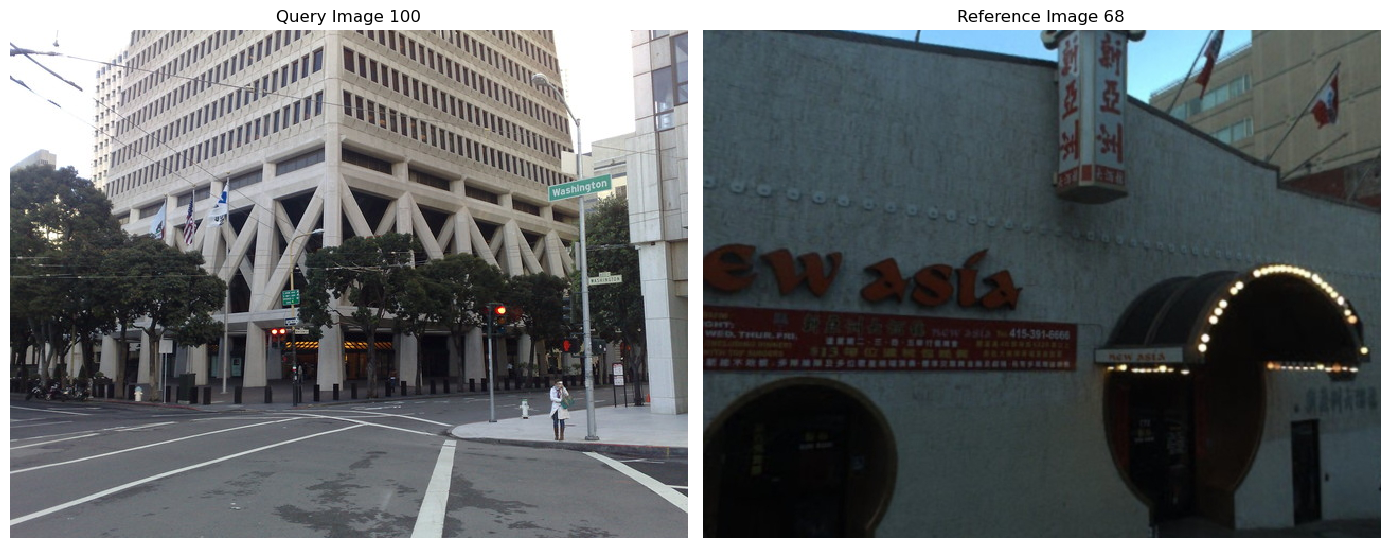

In [6]:
display_side_by_side(cv2.imread('A2_smvs/landmarks/Query/100.jpg'), cv2.imread('A2_smvs/landmarks/Reference/068.jpg'), title1="Query Image 100", title2="Reference Image 68", global_title=None)

**2. Query Image 55:**

   - **Incorrect Match**: The query image `053` was incorrectly matched with reference image `071`.

   - **Correct Match**: The correct match was ranked at position 75.

   - **Possible Explanation**: Although the correct building appears in both images, this match failed due to significant seasonal and environmental differences. The query image was taken in winter, with bare trees exposing most of the building’s features, while the reference image was captured in summer with dense foliage obscuring the facade. As a result, key architectural details were hidden, and only 11 inliers were detected, likely in small, unoccluded regions. The tree itself, being inconsistent between images, did not contribute useful key points, leading the system to deprioritise the correct match. This case highlights how occlusion, lighting changes, and seasonal variation can mislead visual matching algorithms and suppress correct results in the ranking.

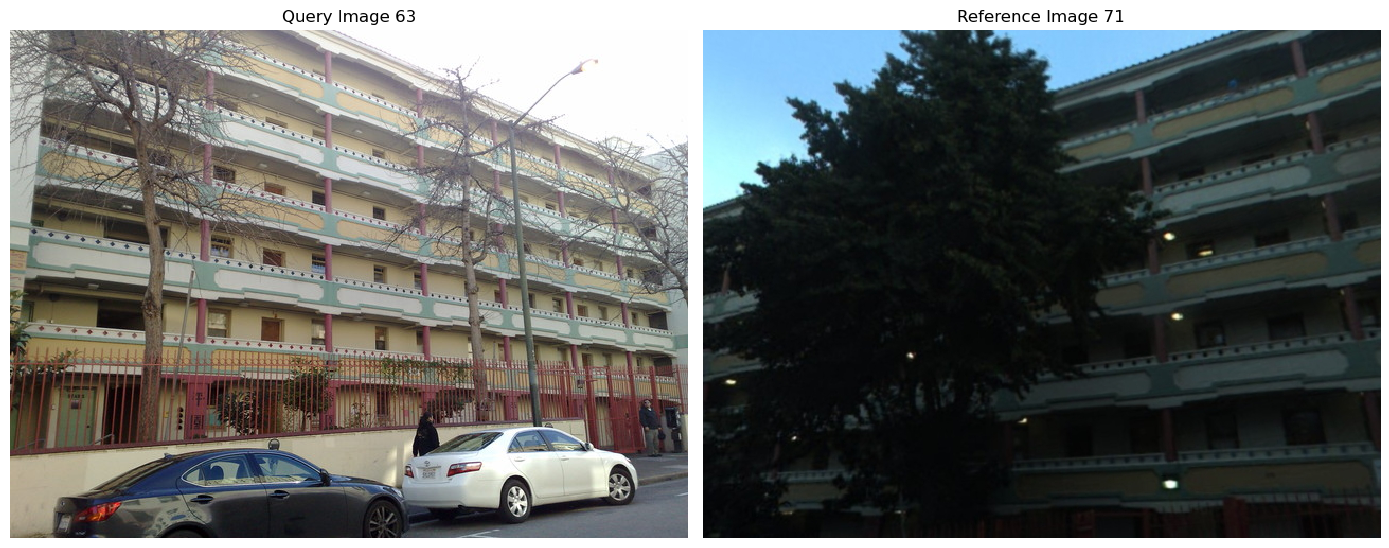

In [7]:
display_side_by_side(cv2.imread('A2_smvs/landmarks/Query/063.jpg'), cv2.imread('A2_smvs/landmarks/Reference/071.jpg'), title1="Query Image 63", title2="Reference Image 71", global_title=None)

To evaluate the algorithm’s ability to correctly reject unfamiliar query images *(True Negatives)* while still correctly matching known ones *(True Positives)*, the experiment was again modified: only half of the reference images were provided, meaning 50 of the 100 query images had no corresponding match in the reference set. This significantly reduced overall performance, especially using the original non-top-k method where accuracy dropped from 19.2% to 16.83%. This occurred because the system struggled with identifying True Negatives, correctly rejecting only 20% of them (10/50). At the same time, it correctly matched only 7/50 True Positives, with most either incorrectly matched to images outside the reference set or simply failing to return any plausible result. The low inlier count likely led to spurious or weak matches that weren't reliable enough to confirm either class.


Adjusting the inlier threshold revealed how sensitive the system is to this parameter. Lowering it to 8 *(to increase inclusiveness and accept weaker matches)* improved the number of True Positives slightly — but at the cost of a dramatic drop in True Negative performance, resulting in an even worse overall accuracy of 8.91%. This makes sense as by loosening the match criteria, the system became more permissive, thus failing to reject dissimilar images. Raising the threshold to 12, on the other hand, improved accuracy to 29.70%. By being stricter more True Negatives were correctly rejected. However, this came at the cost of some True Positives, suggesting a trade-off. While this stricter threshold appears better, it may just be a *data bias illusion*. Increased rejections artificially inflate the True Negative count, masking the fact that fewer True Positives are being correctly identified. Hence, a threshold of around 10 was found to be more balanced.


Introducing the top-k strategy with k=5 showed significant performance improvement. Rather than relying on a single best match, this method allowed the system to consider the top 5 matches, providing more flexibility in decision-making. This led to a notable increase in accuracy to 72.28%, with all True Negatives correctly rejected. The key improvement to achieve such a result is in the system's ability to reject low-confidence matches, which previously might have been misclassified as weak matches when using just k=1. By considering multiple top candidates, the system could confidently reject incorrect matches *(False Positives)* while still recognising the correct match when ranked lower in the list. This results in smarter and more reliable behaviour. Real-world systems often benefit from saying "I don’t know" when the evidence is insufficient, as it avoids the risk of incorrect predictions.


To further improve True Positive performance, image normalisation and histogram equalisation were applied before feature extraction. Unlike the book cover images, this adjustment helped the landscape-format images, likely because it enhanced feature contrast and alignment, improving feature descriptor consistency. As a result, True Positives improved from 22 to 23, a small but meaningful gain in challenging cases. Finally, increasing the number of ORB features from 500 to 1500 further boosted the algorithm's ability to find reliable matches by expanding the descriptor space. This resulted in the best performance observed: 80.29% overall accuracy, with a 60% True Positive match rate, combining strong rejection power with meaningful acceptance of correct matches. This improvement stems from the richer, more descriptive feature set that increases the likelihood of finding strong correspondences even in noisy or altered images.

___

<br/><br/>



## **Question 3: Fundametal Matrix, Epilines and Retrival *(Optional: Assesed for Granting up to 25% Bonus Marks for the A2)***

In this question, the aim is to accuractely estimate the fundamental matrix given two views of a scene, visualise the corresponding epipolar lines and use the inlier count of fundametal matrix for retrival.

**The steps are as follows:**

**1.** Select two images of the same scene *(query and reference)* from the landmark dataset and find the matches as you have done in Question 1 *(1.1-1.4).*


**2.** Compute fundametal matrix with good matches (after appying ratio test) using the opencv function `cv.findFundamentalMat()`. Use both 8 point algorithm and RANSAC assisted 8 point algorithm to compute fundamental matrix.

- **Hint:** You need minimum 8 matches to be able to use the function. Ignore pairs where 8 mathes are not found.


**3.** Visualise the epipolar lines for the matched features and analyse the results. You can use openCV function `cv.computeCorrespondEpilines()` to estimate the epilines. We have provided the code for drawing these epilines in function `drawlines()` that you can modify as required.

In [ ]:
# Load Landmark Images
refImg = cv2.imread('A2_smvs/landmarks/Reference/055.jpg', 0)
if not np.shape(refImg):
  # Error Message & Print Current Working Dir
  print("Could not load refImg. Check the path, filename and current working directory\n")

quyImg = cv2.imread("A2_smvs/landmarks/Query/055.jpg", 0)
if not np.shape(quyImg):
  # Error Message & Print Current Working Dir
  print("Could not load quyImg. Check the path, filename and current working directory\n")

  
# Find the Fundamental Matrix
def fundamentalMatrix(refImg, quyImg):
  """
  Detects and matches features between two images and computes the fundamental matrices using both the 8-point algorithm and RANSAC.
  Parameters:
    refImg (ndarray): The reference (first) grayscale image.
    quyImg (ndarray): The query (second) grayscale image.

  Returns:
    pts1 (ndarray): Matched keypoints in the reference image.
    pts2 (ndarray): Corresponding matched keypoints in the query image.
    F_8 (ndarray): Fundamental matrix computed using the 8-point algorithm.
    F_ransac (ndarray): Fundamental matrix computed using the RANSAC method.
  """
  # Compute  Matches
  _, _, kp1, kp2, matched_img, good_matches = detect_and_match_features(refImg, quyImg, orb_features=500, ratio=0.8, distance_metric=cv2.NORM_HAMMING)

  # Find Fundamental Matrices With & Without RANSAC
  if len(good_matches) >= 8:
      # Extract Point Correspondences
      pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
      pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

      # Estimate Fundamental Matrix using 8-point Algorithm
      F_8, mask_8 = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_8POINT)

      # Estimate Fundamental Matrix using RANSAC
      F_ransac, mask_ransac = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

  else:
      # Print Error Check
      print("Not enough good matches to compute Fundamental Matrix")
  
  # Return Matrices
  return pts1, pts2, F_8, F_ransac


# Calculate Fundamental Matrix
pts1, pts2, F_8, F_ransac = fundamentalMatrix(refImg=refImg, quyImg=quyImg)

# Print the Resulting Matrices
print(f"Fundamental Matrix (8-point):\n{F_8}\n")
print(f"Fundamental Matrix (RANSAC):\n{F_ransac}")

In [ ]:
# Find & Display the Epipolar Lines + Points
def findEpipolar(pts1, pts2, matrix, refImg, quyImg, title):
    # Compute Epilines in the Reference Image for Points in the Query Image (8-Point Method)
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, matrix)
    lines1 = lines1.reshape(-1, 3)

    # Visualise the Epipolar Lines for 8-point Method 
    img1_with_lines, img2_with_points = drawlines(refImg, quyImg, lines1, pts1.astype(int), pts2.astype(int))
    display_side_by_side(img1_with_lines, img2_with_points, title1="Reference Image", title2="Query Image", global_title=title)


# Visualise the Epipolar Lines for 8-point Method 
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_8, refImg=refImg, quyImg=quyImg, title="Epipolar Lines & Points (8-Point)")

# Visualise the Epipolar Lines for RANSAC Method 
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_ransac, refImg=refImg, quyImg=quyImg, title="Epipolar Lines & Points (RANSAC)")

<br/>



**4.** Repeat the steps for some examples from the landmarks datasets.

In [ ]:
# Load Landmark Image 1
refImg1 = cv2.imread('A2_smvs/landmarks/Reference/032.jpg', 0)
if not np.shape(refImg1):
  # Error Message & Print Current Working Dir
  print("Could not load refImg1. Check the path, filename and current working directory\n")

quyImg1 = cv2.imread("A2_smvs/landmarks/Query/032.jpg", 0)
if not np.shape(quyImg1):
  # Error Message & Print Current Working Dir
  print("Could not load quyImg1. Check the path, filename and current working directory\n")

# Visualise the Epipolar Lines & Points
pts1, pts2, F_8, F_ransac = fundamentalMatrix(refImg=refImg1, quyImg=quyImg1)
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_8, refImg=refImg1, quyImg=quyImg1, title="Epipolar Lines & Points (8-Point)")
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_ransac, refImg=refImg1, quyImg=quyImg1, title="Epipolar Lines & Points (RANSAC)")


# Load Landmark Image 2
refImg2 = cv2.imread('A2_smvs/landmarks/Reference/098.jpg', 0)
if not np.shape(refImg2):
  # Error Message & Print Current Working Dir
  print("Could not load refImg2. Check the path, filename and current working directory\n")

quyImg2 = cv2.imread("A2_smvs/landmarks/Query/098.jpg", 0)
if not np.shape(quyImg2):
  # Error Message & Print Current Working Dir
  print("Could not load quyImg2. Check the path, filename and current working directory\n")

# Visualise the Epipolar Lines & Points
pts1, pts2, F_8, F_ransac = fundamentalMatrix(refImg=refImg2, quyImg=quyImg2)
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_8, refImg=refImg2, quyImg=quyImg2, title="Epipolar Lines & Points (8-Point)")
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_ransac, refImg=refImg2, quyImg=quyImg2, title="Epipolar Lines & Points (RANSAC)")


# Load Landmark Image 3
refImg3 = cv2.imread('A2_smvs/landmarks/Reference/076.jpg', 0)
if not np.shape(refImg3):
  # Error Message & Print Current Working Dir
  print("Could not load refImg3. Check the path, filename and current working directory\n")

quyImg3 = cv2.imread("A2_smvs/landmarks/Query/076.jpg", 0)
if not np.shape(quyImg3):
  # Error Message & Print Current Working Dir
  print("Could not load quyImg3. Check the path, filename and current working directory\n")

# Visualise the Epipolar Lines & Points
pts1, pts2, F_8, F_ransac = fundamentalMatrix(refImg=refImg3, quyImg=quyImg3)
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_8, refImg=refImg3, quyImg=quyImg3, title="Epipolar Lines & Points (8-Point)")
findEpipolar(pts1=pts1, pts2=pts2, matrix=F_ransac, refImg=refImg3, quyImg=quyImg3, title="Epipolar Lines & Points (RANSAC)")

<br/>



**5.** Find a query from landmarks data for which the retrival in Q2 failed. Attempt the retrival with replacing the Homography + RANSAC method of Q2 to Fundamental Matrix + RANSAC method using code written above. Does changing the model make the retrival successful? Analyse and comment.

In [ ]:
# Matrix + RANSAC on Image 59 from Landmarks
reference_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Reference/", apply_normalization=False, apply_hist_eq=False)
query_images = loadSubSetImages(limit=101, filepath="A2_smvs/landmarks/Query/", apply_normalization=False, apply_hist_eq=False)

# Cache Reference Descriptors
ref_cache = cache_reference_features(reference_images, orb_features=500)

# Make Accuracy Variables
correct = 0
total = 0

# Top-k for Matching 
top_k = 5

# Run Match for Each Query
for qname, qimg in query_images:
    # Use the Cached Reference Descriptors to Find All Matches Ranked
    ranked_matches = identify_query_object_cached_all(qimg, ref_cache, orb_features=1500)

    # Check if the correct match is in the Top-k Matches
    correct_match_found = False
    correct_index = -1

    for i, (ref_name, _) in enumerate(ranked_matches):
        if ref_name == os.path.splitext(qname)[0]:
            correct_match_found = True
            correct_index = i
            break

    if correct_match_found and correct_index < top_k:
        correct += 1
    else:
        print(f"FAILED TO MATCH:\n Query: {qname} -> Top {top_k} Matches: {[match[0] for match in ranked_matches[:top_k]]}")
        print(f"    Correct match '{qname}' was ranked at position: {correct_index + 1 if correct_index != -1 else 'Not Found'}")

    # Increase Total
    total += 1

# Print out the Total Accuracy
print(f"Overall Accuracy: {correct/total * 100:.2f}%")



***Your analysis goes here***

Image 59 is incorrectly classified in the landmarks in seciton 2. it is given a rnak of 46 and is acutally compared/mathced to imaghe 53 when using K-top  5. 

The discrepancy occurs because when image 059 is matched individually, the system focuses solely on that one comparison, often resulting in a higher inlier count and correct classification. However, within a full query set, increased competition from visually similar images, randomness in RANSAC, and slight variations in feature matching or thresholding can cause the correct match to be overlooked. Additionally, differences in descriptor distribution across the batch may affect ranking, and normalization or filtering applied in batch mode can alter match confidence, leading to misclassification.

Does changing the model make the retrival successful? Analyse and comment.
to keep consisitent you have to run all images on the same data set in the same way. We don't care about clasigingin flase numbers only that ther is 101 things to query. sinince it is al flas postitive we only need to look at accounting for posstive matches like in the first part of question 6. this gives an improvment on accuracy overall of ...

waht was performance in question 6

and we see that image 59 is ... is the rank better?

---
